# Capstone Project - Data Analysis

This is first capstone poject, done during *2021 Python for Machine Learning & Data Science Masterclass* course from udemy- link below:

https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/

----
## Overview
If you are planning on going out to see a movie, how well can you trust online reviews and ratings? *Especially* if the same company showing the rating *also* makes money by selling movie tickets. Do they have a bias towards rating movies higher than they should be rated?

----
### Goal:
**The goal is to determine if Fandango's ratings in 2015 had a bias towards rating movies better to sell more tickets.**

----
### Parts of project:
1. Understanding the Background and Data.
2. Exploring Fandango Displayed Scores versus True User Ratings.
3. Comparison Other Sites.
4. Fandago Scores vs. All Sites.

----
----

## Part One: Understanding the Background and Data.

----
### The Data

This is the data behind the story [Be Suspicious Of Online Movie Ratings, Especially Fandango’s](http://fivethirtyeight.com/features/fandango-movies-ratings/) openly available on 538's github: https://github.com/fivethirtyeight/data. There are two csv files, one with Fandango Stars and Displayed Ratings, and the other with aggregate data for movie ratings from other sites, like Metacritic,IMDB, and Rotten Tomatoes.

----

#### fandango_scape.csv
`fandango_scrape.csv` contains every film 538 pulled from Fandango.

Column | Definiton
--- | ---------
FILM | The movie
STARS | Number of stars presented on Fandango.com
RATING |  The Fandango ratingValue for the film, as pulled from the HTML of each page. This is the actual average score the movie obtained.
VOTES | number of people who had reviewed the film at the time we pulled it.

----

#### all_sites_scores.csv
`all_sites_scores.csv` contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

Column | Definition
--- | -----------
FILM | The film in question
RottenTomatoes | The Rotten Tomatoes Tomatometer score  for the film
RottenTomatoes_User | The Rotten Tomatoes user score for the film
Metacritic | The Metacritic critic score for the film
Metacritic_User | The Metacritic user score for the film
IMDB | The IMDb user score for the film
Metacritic_user_vote_count | The number of user votes the film had on Metacritic
IMDB_user_vote_count | The number of user votes the film had on IMDb

----

## Part Two: Exploring Fandango Displayed Scores versus True User Ratings

Let's first explore the Fandango ratings to see if our analysis agrees with the article's conclusion.

----

In [1]:
# Importing libraries and importing dataset with Fandango ratings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
sns.set_style('darkgrid')

fandango = pd.read_csv("fandango_scrape.csv")

**Exploring the DataFrame Properties and Head.**

In [2]:
# Actually we don't have any null values
fandango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FILM    504 non-null    object 
 1   STARS   504 non-null    float64
 2   RATING  504 non-null    float64
 3   VOTES   504 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 15.9+ KB


In [3]:
# As we can see, there are some things that may be worth looking at:
# A small difference in avg STARS and RATING (maybe due to rounding)
# Not that small diff in 1st quartile of STAR (3.5) and RATING (3.1)
fandango.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
STARS,504.0,3.558532,1.563133,0.0,3.5,4.0,4.50,5.0
RATING,504.0,3.375794,1.491223,0.0,3.1,3.8,4.30,5.0
VOTES,504.0,1147.863095,3830.583136,0.0,3.0,18.5,189.75,34846.0


In [4]:
# We can notice, that most probably FILM contains a year, so we may extract it later to have more info.
fandango.head(20)

,FILM,STARS,RATING,VOTES
0,Fifty Shades of Grey (2015),4.0,3.9,34846
1,Jurassic World (2015),4.5,4.5,34390
2,American Sniper (2015),5.0,4.8,34085
3,Furious 7 (2015),5.0,4.8,33538
4,Inside Out (2015),4.5,4.5,15749
5,The Hobbit: The Battle of the Five Armies (2014),4.5,4.3,15337
6,Kingsman: The Secret Service (2015),4.5,4.2,15205
7,Minions (2015),4.0,4.0,14998
8,Avengers: Age of Ultron (2015),5.0,4.5,14846
9,Into the Woods (2014),3.5,3.4,13055


**Let's explore the relationship between popularity of a film and its rating.**

In [5]:
# Let's create categorical variable STARS, to visualise better
fandango['STARS_CAT'] = fandango['STARS'].astype(object)
fandango['STARS_CAT'].unique()

array([4.0, 4.5, 5.0, 3.5, 3.0, 2.5, 2.0, 1.0, 0.0], dtype=object)

<AxesSubplot:xlabel='RATING', ylabel='VOTES'>

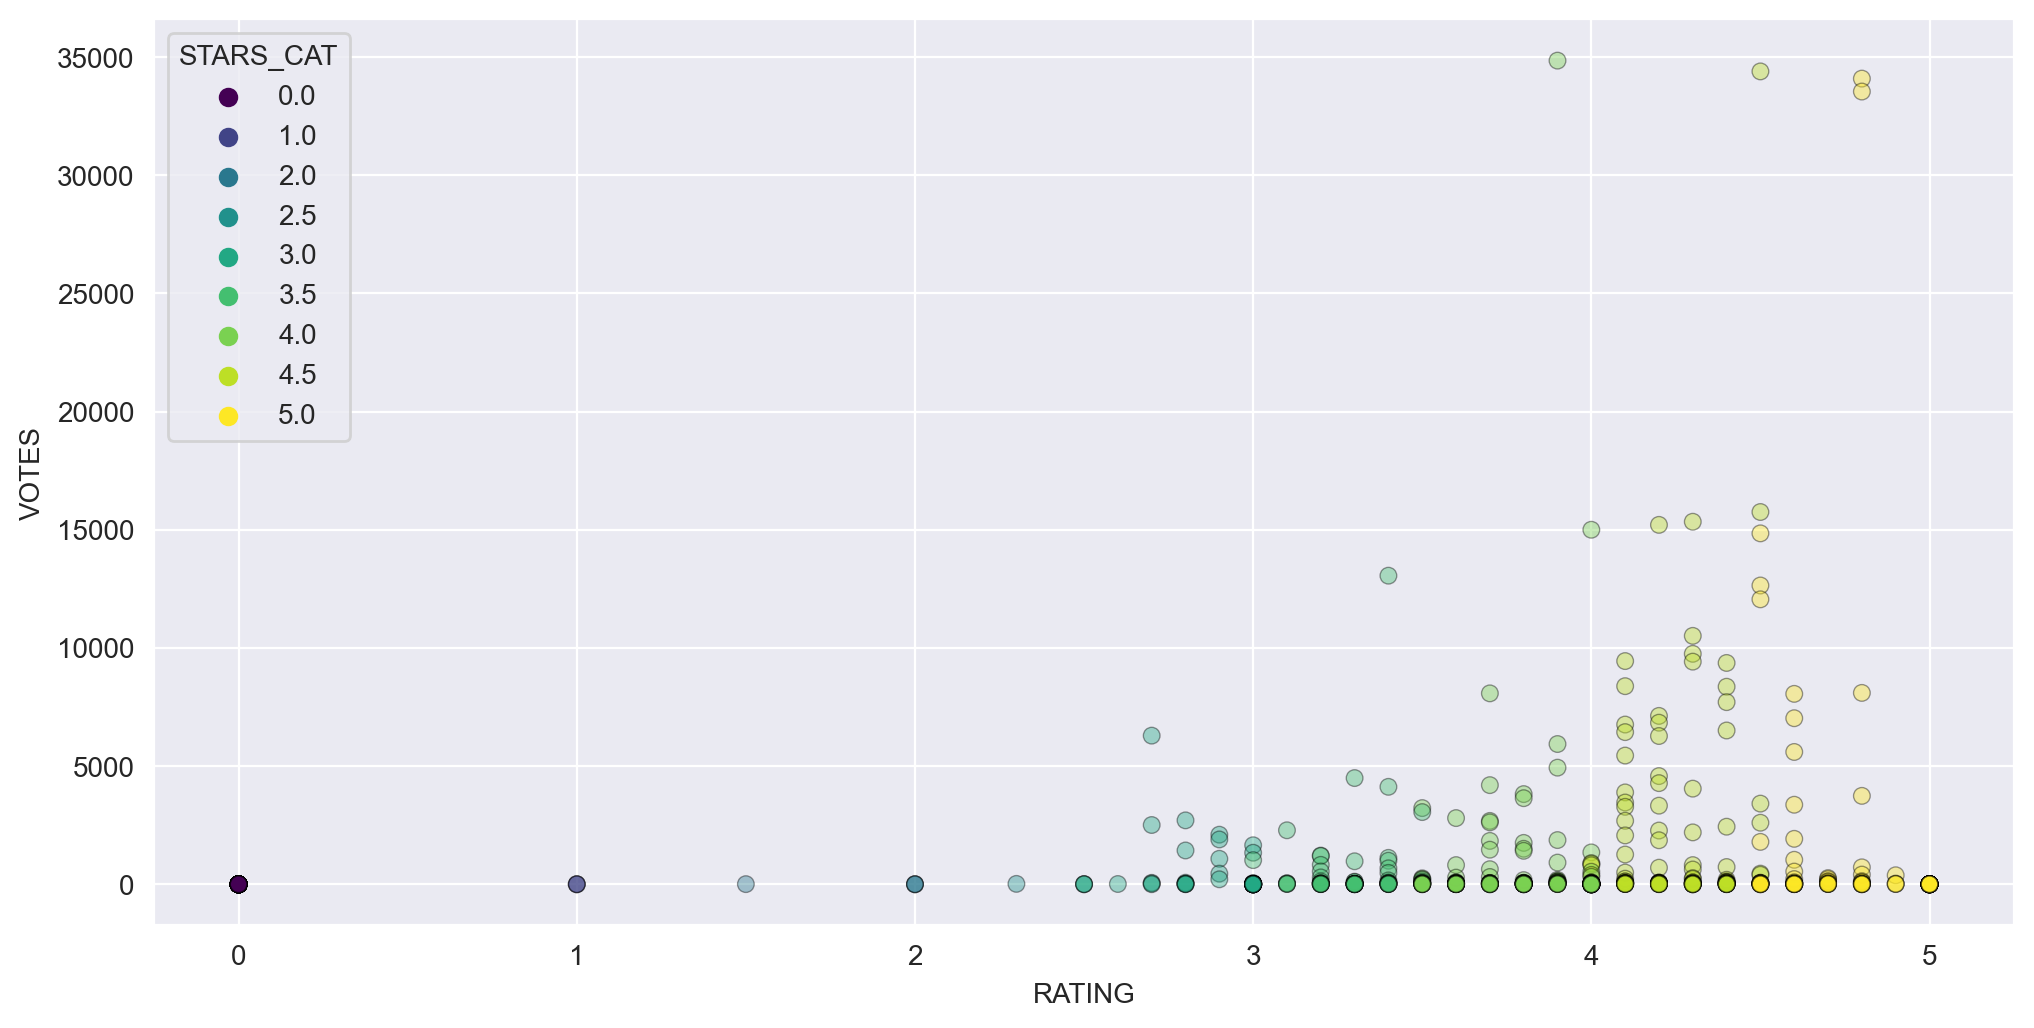

In [6]:
# Plot
# We can notice, thah there are some films, that have 0 votes and 0 rating - we will use that in a moment
plt.figure(figsize=(12,6), dpi=200)
sns.scatterplot(x="RATING", y='VOTES', data=fandango, hue='STARS_CAT', 
                alpha=0.4, edgecolor='black', palette='viridis', legend='full')

In [7]:
# Films with 0 votes and 0 rating
fandango[(fandango['VOTES']==0)&(fandango['RATING']==0)]

,FILM,STARS,RATING,VOTES,STARS_CAT
435,6 Years (2015),0.0,0.0,0,0.0
436,7 Minutes (2015),0.0,0.0,0,0.0
437,A Year in Champagne (2015),0.0,0.0,0,0.0
438,Balls Out (2015),0.0,0.0,0,0.0
439,Before I Wake (2015),0.0,0.0,0,0.0
...,...,...,...,...,...
499,Valiyavan (2015),0.0,0.0,0,0.0
500,WWE SummerSlam 2015 (2015),0.0,0.0,0,0.0
501,Yagavarayinum Naa Kaakka (2015),0.0,0.0,0,0.0
502,"Yesterday, Today and Tomorrow (1964)",0.0,0.0,0,0.0


In [8]:
# Number of films with 0 votes
len(fandango[(fandango['VOTES']==0)&(fandango['RATING']==0)])

69

In [9]:
# Let's make a copy of fandago df and remove films with 0 votes, because they don't provide much info
fdg_rem = fandango.copy()
fdg_rem = fdg_rem[fdg_rem['VOTES']!=0]

In [10]:
print(len(fandango))
print(len(fdg_rem))

504
435


**Assuming that every row in the FILM title column has the same format:**

    Film Title Name (Year), and that Year contains 4 digits
    
**We can create a new column containing YEAR**

In [11]:
fdg_rem['YEAR'] = fdg_rem['FILM'].str[-5:-1:].astype(int)

In [12]:
# Check of values - the vast majority films are from year 2015
fdg_rem['YEAR'].value_counts()

2015    411
2014     23
2016      1
Name: YEAR, dtype: int64

In [13]:
# we can also check the percentage
fdg_rem.groupby('YEAR')['FILM'].count()/len(fdg_rem)*100

YEAR
2014     5.287356
2015    94.482759
2016     0.229885
Name: FILM, dtype: float64

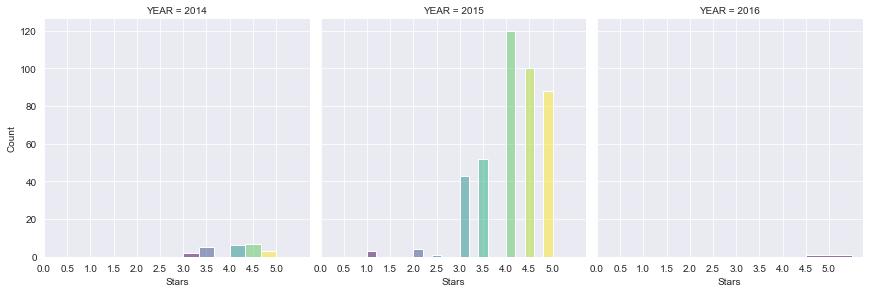

In [14]:
# A quick plot 
g = sns.FacetGrid(fdg_rem, col="YEAR", height=4)
g.map_dataframe(sns.histplot, x="STARS", palette='viridis', hue="STARS")
g.set_axis_labels("Stars", "Count")
g.set(xticks=np.linspace(0,5,11))

In [15]:
# films from 2016
fdg_rem[fdg_rem['YEAR']==2014]

,FILM,STARS,RATING,VOTES,STARS_CAT,YEAR
5,The Hobbit: The Battle of the Five Armies (2014),4.5,4.3,15337,4.5,2014
9,Into the Woods (2014),3.5,3.4,13055,3.5,2014
14,Unbroken (2014),4.5,4.1,9443,4.5,2014
21,The Imitation Game (2014),5.0,4.6,8055,5.0,2014
24,Selma (2014),5.0,4.6,7025,5.0,2014
25,Annie (2014),4.5,4.2,6835,4.5,2014
33,Night at the Museum: Secret of the Tomb (2014),4.5,4.1,5445,4.5,2014
38,Birdman (2014),4.0,3.7,4194,4.0,2014
50,Top Five (2014),4.0,3.5,3223,4.0,2014
73,Big Eyes (2014),4.0,3.8,1501,4.0,2014


In [16]:
# only one film from 2016
fdg_rem[fdg_rem['YEAR']==2016]

,FILM,STARS,RATING,VOTES,STARS_CAT,YEAR
286,Deadpool (2016),5.0,4.7,11,5.0,2016


----

**As noted in the article, due to HTML and star rating displays, the true user rating may be slightly different than the rating shown to a user.**

**A KDE plots will display the distribution of ratings that are displayed (STARS) versus what the true rating was from votes (RATING).**

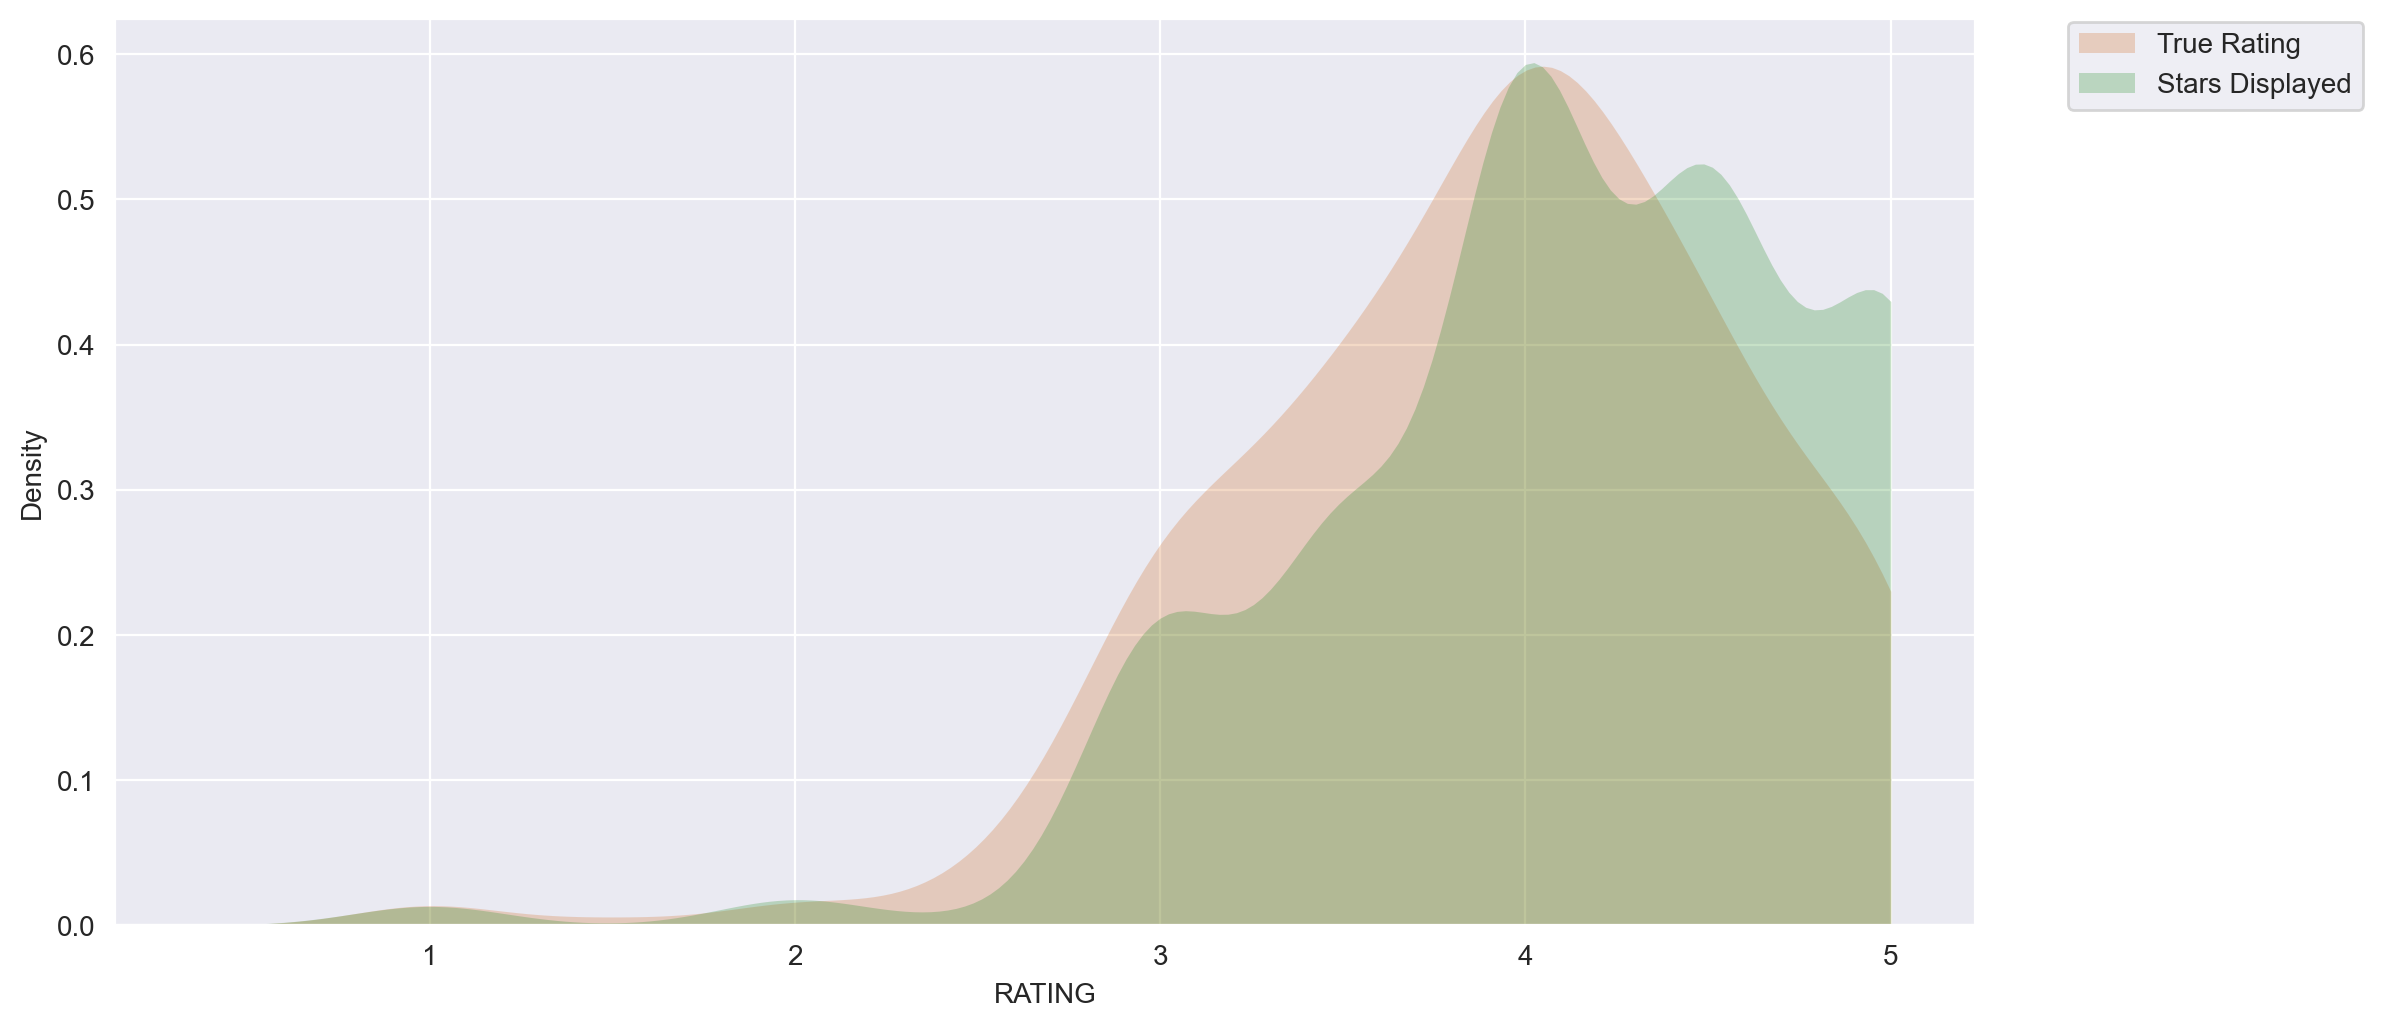

In [17]:
# We can see, that there's a discrepancy betweend distributions. Between rating 4-5, Stars Displayed (STARS) tends 
# to appear more often than they should be - according to True Rating.
# On the other hand, with rating lower than 4, we can see the opposite case.
plt.figure(figsize=(12,6), dpi=200)
sns.kdeplot(data=fdg_rem,x='RATING',clip=[0,5],label='True Rating',fill=True, linewidth=0, color="chocolate")
sns.kdeplot(data=fdg_rem['STARS'],clip=[0,5],label='Stars Displayed',fill=True, linewidth=0, color="forestgreen")

plt.legend(loc=(1.05,0.9))
plt.show()

**Let's  actually quantify this discrepancy. We will make a new column with the difference between STARS displayed versus true RATING.**

In [18]:
fdg_rem['STARS_DIFF'] = (fdg_rem["STARS"] - fdg_rem["RATING"]).round(2)

In [19]:
fdg_rem[["FILM","RATING","STARS",'STARS_DIFF']]

,FILM,RATING,STARS,STARS_DIFF
0,Fifty Shades of Grey (2015),3.9,4.0,0.1
1,Jurassic World (2015),4.5,4.5,0.0
2,American Sniper (2015),4.8,5.0,0.2
3,Furious 7 (2015),4.8,5.0,0.2
4,Inside Out (2015),4.5,4.5,0.0
...,...,...,...,...
430,That Sugar Film (2015),5.0,5.0,0.0
431,The Intern (2015),5.0,5.0,0.0
432,The Park Bench (2015),5.0,5.0,0.0
433,The Wanted 18 (2015),5.0,5.0,0.0


**Count values and quick plot.**


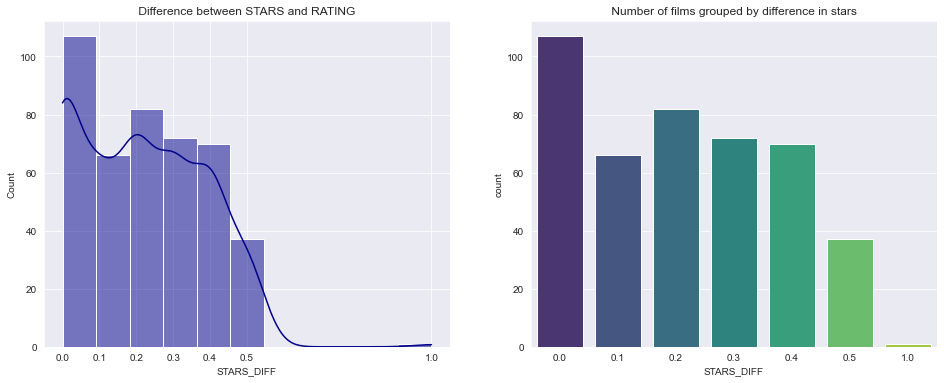

In [20]:
# plot
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x="STARS_DIFF", data=fdg_rem, bins=11,kde=True, ax=ax[0], color='darkblue')
ax[0].set_title(" Difference between STARS and RATING ")
ax[0].set_xticks(fdg_rem['STARS_DIFF'].unique())
sns.countplot(x="STARS_DIFF", data=fdg_rem, palette='viridis', ax=ax[1])
ax[1].set_title(" Number of films grouped by difference in stars ");

Actually, **there's not a single film, that has a negative difference** - <u>so none of the films has less STARS than RATING. </u>

In [21]:
# count
# Also there are 37 films with a 0.5 difference and even 1 film with 1 star difference...
# fdg_rem['STARS_DIFF'].value_counts()
fdg_rem.groupby('STARS_DIFF').count()['FILM']

STARS_DIFF
0.0    107
0.1     66
0.2     82
0.3     72
0.4     70
0.5     37
1.0      1
Name: FILM, dtype: int64

In [22]:
# And percentage
perc_STARS_DIFF = fdg_rem.groupby('STARS_DIFF')['FILM'].count()/len(fdg_rem)*100
perc_STARS_DIFF = perc_STARS_DIFF.reset_index().sort_values('STARS_DIFF')
perc_STARS_DIFF.rename(columns={"FILM": "PERCENTAGE"}, inplace=True)
perc_STARS_DIFF

,STARS_DIFF,PERCENTAGE
0,0.0,24.597701
1,0.1,15.172414
2,0.2,18.850575
3,0.3,16.551724
4,0.4,16.091954
5,0.5,8.505747
6,1.0,0.229885


In [23]:
# Percentage of films with STARS_DIFF > 0.3 (0.3 because if film gets 4.2 rating, it probably should have 4 stars not 4.5.)
# Over 41% of films have higher diff than probaby they should.
perc_STARS_DIFF[perc_STARS_DIFF['STARS_DIFF']>=0.3]["PERCENTAGE"].sum().round(2)

41.38

In [24]:
# we may want to keep names of films with biggest STARS_DIFF
star_diff_df = pd.DataFrame(fdg_rem[fdg_rem["STARS_DIFF"].isin([1,.5,.4,.3])])[['FILM', 'STARS_DIFF','VOTES']]
star_diff_df = star_diff_df.sort_values("STARS_DIFF", ascending=False)
star_diff_df

,FILM,STARS_DIFF,VOTES
381,Turbo Kid (2015),1.0,2
383,Felt (2015),0.5,2
169,Royal Ballet: Swan Lake (2015),0.5,59
227,The Algerian (2015),0.5,23
200,Premam (2015),0.5,40
...,...,...,...
233,Batkid Begins (2015),0.3,22
232,Jil (2015),0.3,22
97,Monkey Kingdom (2015),0.3,701
99,American Ultra (2015),0.3,638


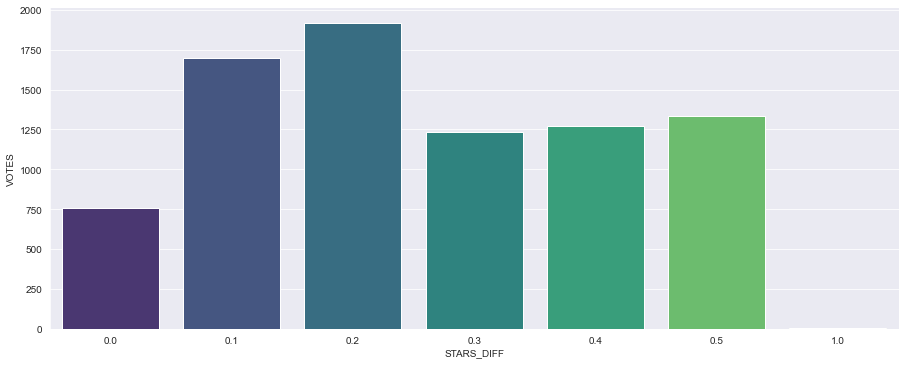

In [25]:
# We can check the relation between STARS_DIFF and VOTES
# Highly voted films has "acceptable" star diff, films with low votes tends not to have that difference
# Films with highest starr difference has an avg number of votes 
sns.catplot(y="VOTES",x='STARS_DIFF',data=fdg_rem,kind="bar", ci=None, aspect=2.5, palette='viridis')

In [26]:
# Let's see if STARS_DIFF of films with most votes match any pattern
fdg_rem.sort_values("VOTES", ascending=False)[0:10][['FILM','VOTES', 'STARS','STARS_DIFF']]

,FILM,VOTES,STARS,STARS_DIFF
0,Fifty Shades of Grey (2015),34846,4.0,0.1
1,Jurassic World (2015),34390,4.5,0.0
2,American Sniper (2015),34085,5.0,0.2
3,Furious 7 (2015),33538,5.0,0.2
4,Inside Out (2015),15749,4.5,0.0
5,The Hobbit: The Battle of the Five Armies (2014),15337,4.5,0.2
6,Kingsman: The Secret Service (2015),15205,4.5,0.3
7,Minions (2015),14998,4.0,0.0
8,Avengers: Age of Ultron (2015),14846,5.0,0.5
9,Into the Woods (2014),13055,3.5,0.1


In [27]:
# On the other hand, less popular films (lower votes) don't seem to have STAR_DIFF 
fdg_rem.sort_values("VOTES")[0:10][['FILM','VOTES', 'STARS','STARS_DIFF']]

,FILM,VOTES,STARS,STARS_DIFF
434,Z For Zachariah (2015),1,5.0,0.0
413,Wild Canaries (2015),1,3.0,0.0
412,The Living (2015),1,3.0,0.0
411,The Face of an Angel (2015),1,3.0,0.0
410,"One Cut, One Life (2015)",1,3.0,0.0
409,Nannbenda (2015),1,3.0,0.0
408,Hungry Hearts (2015),1,3.0,0.0
414,Buggs Bunny (2015),1,4.0,0.0
407,Empire of Lust (2015),1,3.0,0.0
405,Amour Fou (2015),1,3.0,0.0


## Part Three: Comparison Other Sites

Quick reminder:

#### all_sites_scores.csv
`all_sites_scores.csv` contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

Column | Definition
--- | -----------
FILM | The film in question
RottenTomatoes | The Rotten Tomatoes Tomatometer score  for the film
RottenTomatoes_User | The Rotten Tomatoes user score for the film
Metacritic | The Metacritic critic score for the film
Metacritic_User | The Metacritic user score for the film
IMDB | The IMDb user score for the film
Metacritic_user_vote_count | The number of user votes the film had on Metacritic
IMDB_user_vote_count | The number of user votes the film had on IMDb

----





**Now let's compare the scores from Fandango to other movies sites and see how they compare.**

**Explore the DataFrame columns, info, description.**

In [28]:
all_sites = pd.read_csv("all_sites_scores.csv")

In [29]:
# no nulls, much less films to compare
all_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Metacritic_user_vote_count  146 non-null    int64  
 7   IMDB_user_vote_count        146 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 9.2+ KB


In [30]:
# we can notice, that different services had different scales rating, we will correct that later
# also only rotten tomatoes have some 100 out of 100 ratings (fandango also had, other services don't)
all_sites.describe()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,60.849315,63.876712,58.808219,6.519178,6.736986,185.705479,42846.205479
std,30.168799,20.024430,19.517389,1.510712,0.958736,316.606515,67406.509171
min,5.000000,20.000000,13.000000,2.400000,4.000000,4.000000,243.000000
25%,31.250000,50.000000,43.500000,5.700000,6.300000,33.250000,5627.000000
50%,63.500000,66.500000,59.000000,6.850000,6.900000,72.500000,19103.000000
75%,89.000000,81.000000,75.000000,7.500000,7.400000,168.500000,45185.750000
max,100.000000,94.000000,94.000000,9.600000,8.600000,2375.000000,334164.000000


In [31]:
all_sites.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,1330,271107
1,Cinderella (2015),85,80,67,7.5,7.1,249,65709
2,Ant-Man (2015),80,90,64,8.1,7.8,627,103660
3,Do You Believe? (2015),18,84,22,4.7,5.4,31,3136
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,88,19560


### Rotten Tomatoes

Let's first take a look at Rotten Tomatoes. RT has two sets of reviews, their critics reviews (ratings published by official critics) and user reviews. 

**Scatterplot can explore the relationship between RT Critic reviews and RT User reviews.**

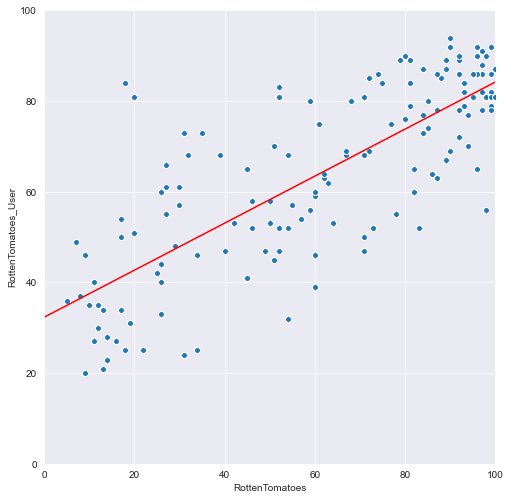

In [32]:
# fit
m,b = np.polyfit(all_sites["RottenTomatoes"], all_sites['RottenTomatoes_User'], 1)
# coefs
X_plot = np.linspace(0, 100, 100)
Y_plot = m*X_plot+b
# plot - we can see quite linear relation between reviews, so as critics reviews are higher, so the user's are
g = sns.FacetGrid(all_sites, height = 7)
g = g.map(plt.scatter, "RottenTomatoes", "RottenTomatoes_User", edgecolor="w")
plt.ylim(0,100)
plt.xlim(0,100)
plt.plot(X_plot, Y_plot, color='r')
plt.show()

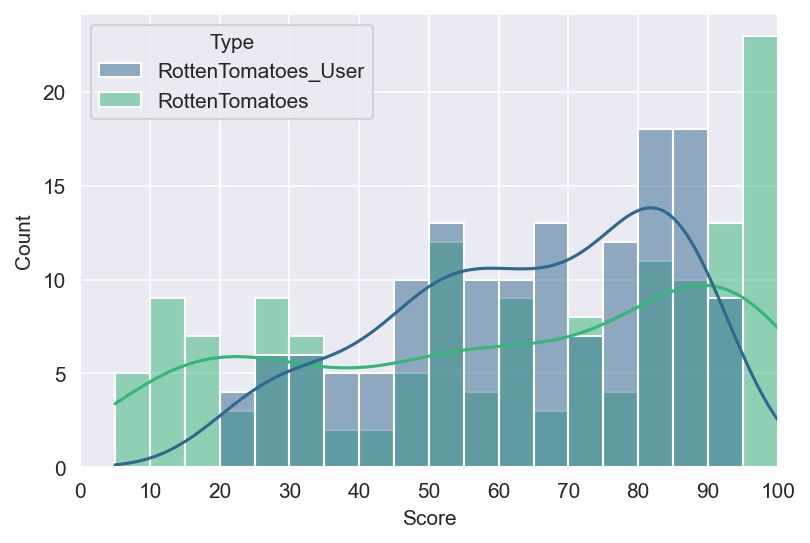

In [33]:
# we can see that  RT users rate movies between 35 and 90 more often than critics, but on the other hand they don't 
# rate movies below 20 or above 95.
test=all_sites[['RottenTomatoes_User','RottenTomatoes']].copy()
test.reset_index(inplace=True)
test = pd.melt(test, id_vars='index', value_vars=['RottenTomatoes_User', 'RottenTomatoes'],
               value_name="Score", var_name="Type")
plt.figure(dpi=150)
plt.xlim(0,100)
plt.xticks(np.linspace(0,100,11))
sns.histplot(data=test, x="Score", hue="Type",bins=19,kde=True, palette='viridis');

**Let's quantify this difference by comparing the critics ratings and the RT User ratings.** 

We will calculate this with RottenTomatoes-RottenTomatoes_User. Note: Rotten_Diff here is Critics - User Score. So values closer to 0 means aggrement between Critics and Users. Larger positive values means critics rated much higher than users. Larger negative values means users rated much higher than critics.

In [34]:
all_sites['RottenTomatoes_Diff'] = all_sites['RottenTomatoes'] - all_sites['RottenTomatoes_User']
all_sites['RottenTomatoes_Diff'] 

0     -12
1       5
2     -10
3     -66
4     -14
       ..
141     9
142    15
143    19
144    19
145    24
Name: RottenTomatoes_Diff, Length: 146, dtype: int64

Let's now compare the overall mean difference. Since we're dealing with differences that could be negative or positive, first we'll take the absolute value of all the differences, then take the mean. This would report back on average to absolute difference between the critics rating versus the user rating.

**Mean Absolute Difference between RT scores and RT User scores as described above.**

In [35]:
rt_diff = round(abs(all_sites['RottenTomatoes_Diff']).mean(),2)
rt_diff

15.1

**Distribution of the differences between RT Critics Score and RT User Score.**

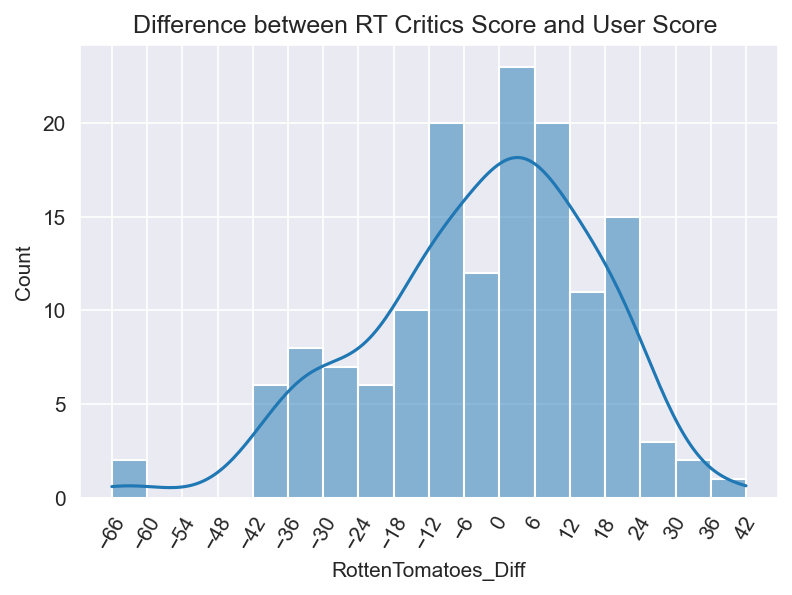

In [36]:
# plot - we can notice that it fits normal distribution quite well
plt.figure(dpi=150)
X_range = np.linspace(min(all_sites['RottenTomatoes_Diff']),max(all_sites['RottenTomatoes_Diff']),19)
sns.histplot(x="RottenTomatoes_Diff", data=all_sites, kde=True, bins=18)
plt.title("Difference between RT Critics Score and User Score ")
plt.xticks(X_range, rotation=60)
plt.show()

**Now  a distribution showing the *absolute value* difference between Critics and Users on Rotten Tomatoes.**

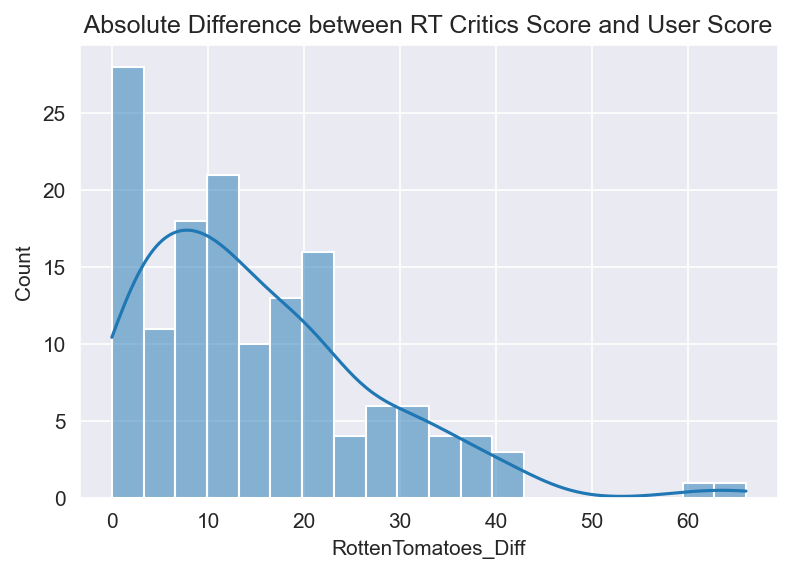

In [37]:
plt.figure(dpi=150)
sns.histplot(x="RottenTomatoes_Diff", data=abs(all_sites[['RottenTomatoes_Diff']]), kde=True, bins=20)
plt.title(" Absolute Difference between RT Critics Score and User Score ")
plt.show()

**Let's find out which movies are causing the largest differences. First, show the top 5 movies with the largest *negative* difference between Users and RT critics. Since we calculated the difference as Critics Rating - Users Rating, then large negative values imply the users rated the movie much higher on average than the critics did.**

In [38]:
print('Top 5 movies users rated higher than critics on average')
all_sites.sort_values("RottenTomatoes_Diff")[["FILM", "RottenTomatoes_Diff"]].head()

Top 5 movies users rated higher than critics on average


,FILM,RottenTomatoes_Diff
3,Do You Believe? (2015),-66
85,Little Boy (2015),-61
134,The Longest Ride (2015),-42
105,Hitman: Agent 47 (2015),-42
125,The Wedding Ringer (2015),-39


**And on the other hand, top5 movies scored better by critics.**

In [39]:
print('Top 5 movies critics scores higher than users on average')
all_sites.sort_values("RottenTomatoes_Diff", ascending=False)[["FILM", "RottenTomatoes_Diff"]].head()

Top 5 movies critics scores higher than users on average


,FILM,RottenTomatoes_Diff
69,Mr. Turner (2014),42
112,It Follows (2015),31
115,While We're Young (2015),31
145,"Kumiko, The Treasure Hunter (2015)",24
37,Welcome to Me (2015),24


## MetaCritic

Now let's take a quick look at the ratings from MetaCritic. Metacritic also shows an average user rating versus their official displayed rating.

**A scatterplot of the Metacritic Rating versus the Metacritic User rating.**

In [40]:
# as the scales of rating are different, we'll create a new df to correct it
test1=all_sites[['Metacritic','Metacritic_User']].copy()
test1.reset_index(inplace=True)
test1['Metacritic_User']= (10*test1['Metacritic_User']).astype(int)
test1

,index,Metacritic,Metacritic_User
0,0,66,71
1,1,67,75
2,2,64,81
3,3,22,47
4,4,29,34
...,...,...,...
141,141,67,79
142,142,83,75
143,143,89,88
144,144,90,73


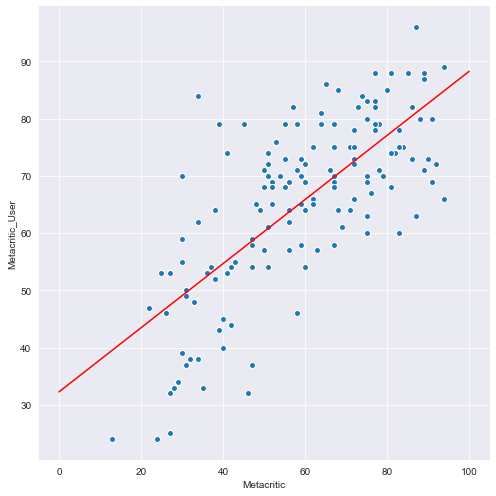

In [41]:
# fit
m,b = np.polyfit(test1["Metacritic"], test1['Metacritic_User'], 1)

# coefs
X_plot = np.linspace(0, 100, 100)
Y_plot = m*X_plot+b

# plot - we can see quite linear relation between reviews, so as critics reviews are higher, so the user's are
g = sns.FacetGrid(test1, height = 7)
g = g.map(plt.scatter, "Metacritic", "Metacritic_User", edgecolor="w")
plt.plot(X_plot, Y_plot, color='r')
plt.show()

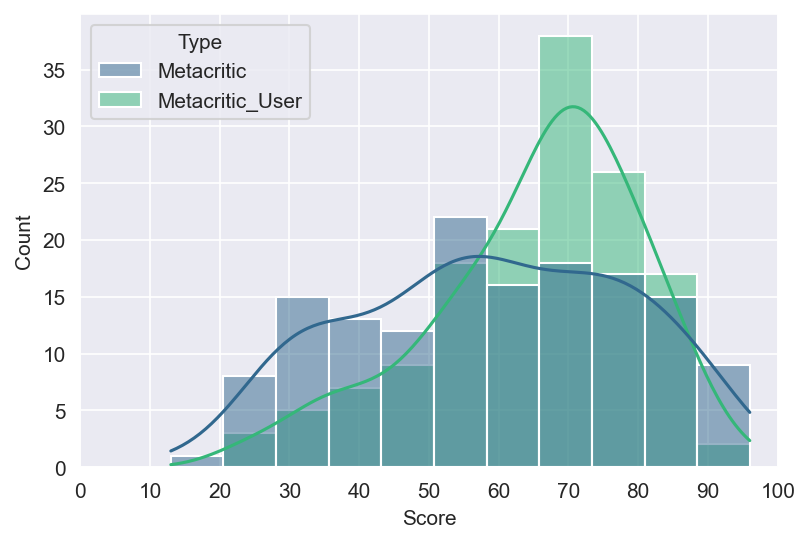

In [42]:
# we melt test1 df to create categorical var, so we can easily plot it
test2 = pd.melt(test1, id_vars='index', value_vars=['Metacritic', 'Metacritic_User'],value_name="Score", var_name="Type")

# as we could notice from the .describe table, metacritic users tends to rate movies higher than critics (on average)
plt.figure(dpi=150)
plt.xlim(0,100)
plt.xticks(np.linspace(0,100,11))
sns.histplot(data=test2, x="Score", hue="Type",bins=11,kde=True, palette='viridis');

## IMDB

**Finally let's explore IMDB. Notice that both Metacritic and IMDB report back vote counts. Let's analyze the most popular movies.**


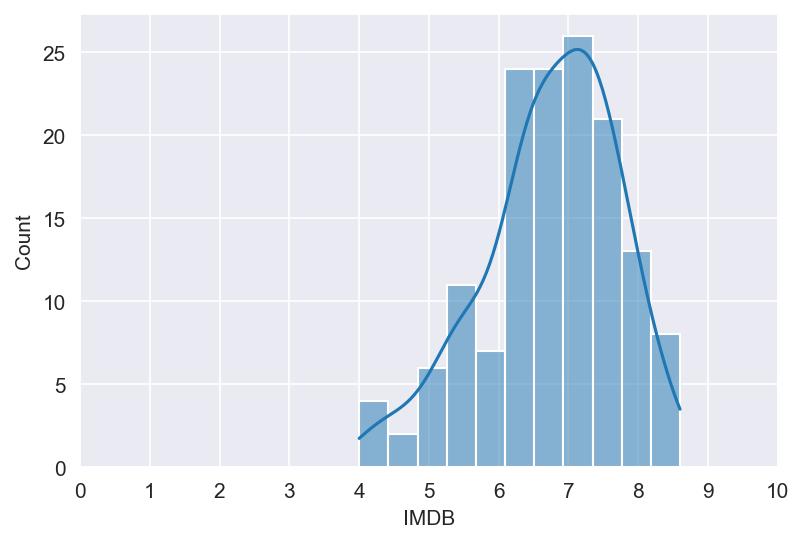

In [43]:
# distribution of IMDB reviews
plt.figure(dpi=150)
plt.xlim(0,10)
plt.xticks(np.linspace(0,10,11))
sns.histplot(data=all_sites, x="IMDB",bins=11,kde=True, palette='viridis');

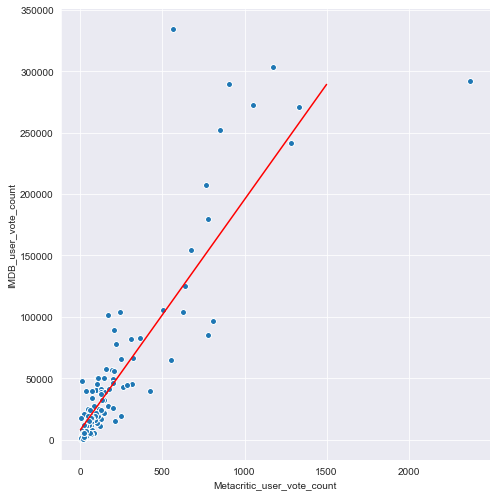

In [44]:
# Scatterplot of vote_count - we can clearly see 2 outliers
# fit
m,b = np.polyfit(all_sites["Metacritic_user_vote_count"], all_sites['IMDB_user_vote_count'], 1)

# coefs
X_plot = np.linspace(0, 1500, 100)
Y_plot = m*X_plot+b

# plot - we can see quite linear relation between reviews, so as critics reviews are higher, so the user's are
g = sns.FacetGrid(all_sites, height = 7)
g = g.map(plt.scatter, "Metacritic_user_vote_count", "IMDB_user_vote_count", edgecolor="w")
plt.plot(X_plot, Y_plot, color='r')
plt.show()

**Notice there are two outliers here. The movie with the highest vote count on IMDB only has about 500 Metacritic ratings.**


In [45]:
all_sites.iloc[all_sites['IMDB_user_vote_count'].idxmax()]

FILM                          The Imitation Game (2014)
RottenTomatoes                                       90
RottenTomatoes_User                                  92
Metacritic                                           73
Metacritic_User                                     8.2
IMDB                                                8.1
Metacritic_user_vote_count                          566
IMDB_user_vote_count                             334164
RottenTomatoes_Diff                                  -2
Name: 14, dtype: object

**What movie has the highest Metacritic User Vote count?**

In [46]:
all_sites.iloc[all_sites['Metacritic_user_vote_count'].idxmax()]

FILM                          Mad Max: Fury Road (2015)
RottenTomatoes                                       97
RottenTomatoes_User                                  88
Metacritic                                           89
Metacritic_User                                     8.7
IMDB                                                8.3
Metacritic_user_vote_count                         2375
IMDB_user_vote_count                             292023
RottenTomatoes_Diff                                   9
Name: 88, dtype: object

## Fandago Scores vs. All Sites

Finally let's begin to explore whether or not Fandango artificially displays higher ratings than warranted to boost ticket sales.

**Let's combine the Fandango Table with the All Sites table.**

In [47]:
# merging and basic info
df = pd.merge(fdg_rem, all_sites)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        145 non-null    object 
 1   STARS                       145 non-null    float64
 2   RATING                      145 non-null    float64
 3   VOTES                       145 non-null    int64  
 4   STARS_CAT                   145 non-null    object 
 5   YEAR                        145 non-null    int32  
 6   STARS_DIFF                  145 non-null    float64
 7   RottenTomatoes              145 non-null    int64  
 8   RottenTomatoes_User         145 non-null    int64  
 9   Metacritic                  145 non-null    int64  
 10  Metacritic_User             145 non-null    float64
 11  IMDB                        145 non-null    float64
 12  Metacritic_user_vote_count  145 non-null    int64  
 13  IMDB_user_vote_count        145 non

In [48]:
# first few rows
df.head()

,FILM,STARS,RATING,VOTES,STARS_CAT,YEAR,STARS_DIFF,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count,RottenTomatoes_Diff
0,Fifty Shades of Grey (2015),4.0,3.9,34846,4.0,2015,0.1,25,42,46,3.2,4.2,778,179506,-17
1,Jurassic World (2015),4.5,4.5,34390,4.5,2015,0.0,71,81,59,7.0,7.3,1281,241807,-10
2,American Sniper (2015),5.0,4.8,34085,5.0,2015,0.2,72,85,72,6.6,7.4,850,251856,-13
3,Furious 7 (2015),5.0,4.8,33538,5.0,2015,0.2,81,84,67,6.8,7.4,764,207211,-3
4,Inside Out (2015),4.5,4.5,15749,4.5,2015,0.0,98,90,94,8.9,8.6,807,96252,8


### Normalize columns to Fandango STARS and RATINGS 0-5 

**We noticed that different services has different scales. Also RT, Metacritic and IMDB don't use a score between 0-5 stars like Fandango does.**

**In order to do a fair comparison, we need to *normalize* these values so they all fall between 0-5 stars and the relationship between reviews stays the same.**

In [49]:
# Normalize Rotten Tomatoes and Metacritic scores by dividing by 20 (max score 100), and rounding
df[['RotTom_Norm','RotTomUs_Norm','Met_Norm']] = (df[['RottenTomatoes','RottenTomatoes_User','Metacritic']] / 20).round(1)

In [50]:
# Normalize IMDB and Metacritic_User scores by dividing by 2 (max score 10), and rounding
df[['IMDB_Norm','MetUs_Norm']] = (df[['IMDB','Metacritic_User']] / 2).round(1)

In [51]:
# check
df.iloc[:,-5:-1].head()

,RotTom_Norm,RotTomUs_Norm,Met_Norm,IMDB_Norm
0,1.2,2.1,2.3,2.1
1,3.6,4.0,3.0,3.6
2,3.6,4.2,3.6,3.7
3,4.0,4.2,3.4,3.7
4,4.9,4.5,4.7,4.3


**Now we will create a norm_scores DataFrame that only contains the normalizes ratings, including both STARS and RATING from the original Fandango table.**

In [52]:
# making a copy of full df and later dropping columns
norm_df = df.copy()
to_drop = ['STARS_CAT',"STARS_DIFF",'Metacritic_user_vote_count','IMDB_user_vote_count','RottenTomatoes_Diff',"VOTES",
           "YEAR","RottenTomatoes","RottenTomatoes_User","Metacritic","Metacritic_User", "IMDB"]
norm_df.drop(columns=to_drop, inplace=True)
norm_df.head(1)

,FILM,STARS,RATING,RotTom_Norm,RotTomUs_Norm,Met_Norm,IMDB_Norm,MetUs_Norm
0,Fifty Shades of Grey (2015),4.0,3.9,1.2,2.1,2.3,2.1,1.6


In [53]:
# lets rename STARS and RATING
norm_df.rename(columns={"STARS":"Fan_Star","RATING":"Fan_True"}, inplace=True)

In [54]:
# # we split names of columns with "_"
temp = norm_df[norm_df.columns[3:8]].columns.str.split("_")
# # then we use list comprehension to extract names
temp = [temp[i][0] for i in range(len(temp))]
temp
# df_comp.columns[5:10]

['RotTom', 'RotTomUs', 'Met', 'IMDB', 'MetUs']

In [55]:
# also, lets cut "_Norm" from the rest of column names
norm_df.rename(columns=dict(zip(norm_df.iloc[:, 3:8].columns, temp)), inplace=True)
norm_df.head(1)

,FILM,Fan_Star,Fan_True,RotTom,RotTomUs,Met,IMDB,MetUs
0,Fifty Shades of Grey (2015),4.0,3.9,1.2,2.1,2.3,2.1,1.6


### We also compare the movies with highest difference in STARS vs RATING from Fandango with ratings from other services

In [56]:
# there are 72 films which we can compare
df_comp = pd.merge(star_diff_df,norm_df, on="FILM")
df_comp.shape

(72, 10)

In [57]:
df_comp.sort_values("STARS_DIFF", ascending=False)

,FILM,STARS_DIFF,VOTES,Fan_Star,Fan_True,RotTom,RotTomUs,Met,IMDB,MetUs
0,Black Sea (2015),0.5,218,4.0,3.5,4.1,3.0,3.1,3.2,3.3
7,Far From The Madding Crowd (2015),0.5,804,4.5,4.0,4.2,3.8,3.6,3.6,3.8
12,Ant-Man (2015),0.5,12055,5.0,4.5,4.0,4.5,3.2,3.9,4.0
11,Cinderella (2015),0.5,12640,5.0,4.5,4.2,4.0,3.4,3.6,3.8
10,Leviathan (2014),0.5,64,4.0,3.5,5.0,4.0,4.6,3.8,3.6
...,...,...,...,...,...,...,...,...,...,...
47,The DUFF (2015),0.3,2273,4.5,4.2,3.6,3.4,2.8,3.3,3.2
46,Unfriended (2015),0.3,2507,3.0,2.7,3.0,2.0,3.0,3.0,2.9
45,Hot Pursuit (2015),0.3,2618,4.0,3.7,0.4,1.8,1.6,2.4,1.8
44,The Gift (2015),0.3,2680,4.0,3.7,4.6,4.0,3.8,3.8,4.2


**We can subtract mean of other's services reviews from Fandango's STARS to see how big the differece is.**

In [58]:
df_comp["Rot_Met_IMDB_Mean"]= df_comp.drop(columns=['STARS_DIFF',"VOTES",'Fan_True', 'Fan_Star']).mean(axis=1).round(1)

In [59]:
df_comp['FanStar-Mean'] = (df_comp['Fan_Star'] - df_comp['Rot_Met_IMDB_Mean']).round(1)
# seems to work properly
df_comp.head(4)

,FILM,STARS_DIFF,VOTES,Fan_Star,Fan_True,RotTom,RotTomUs,Met,IMDB,MetUs,Rot_Met_IMDB_Mean,FanStar-Mean
0,Black Sea (2015),0.5,218,4.0,3.5,4.1,3.0,3.1,3.2,3.3,3.3,0.7
1,Irrational Man (2015),0.5,252,4.0,3.5,2.1,2.6,2.6,3.4,3.8,2.9,1.1
2,Do You Believe? (2015),0.5,1793,5.0,4.5,0.9,4.2,1.1,2.7,2.4,2.3,2.7
3,The Water Diviner (2015),0.5,397,4.5,4.0,3.2,3.1,2.5,3.6,3.4,3.2,1.3


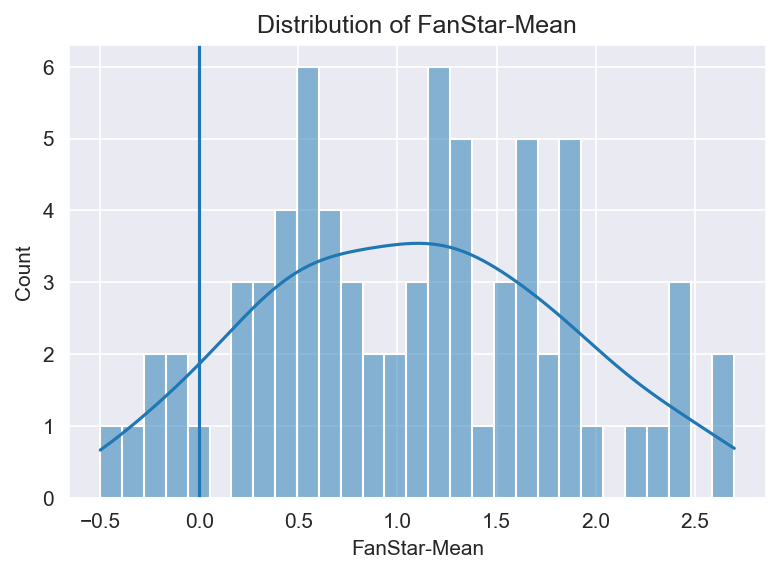

In [60]:
# plot of the values of FanStar-Mean - we can see, that after subtraction there are much more positive values.
# It means that the Fan_Star was higher then the mean. Blue vertical line at x=0 placed to show it even better.
plt.figure(dpi=150)
fsm_bins = len(df_comp['FanStar-Mean'].unique())

sns.histplot(x='FanStar-Mean', data=df_comp, kde=True, bins=fsm_bins)
plt.title(" Distribution of FanStar-Mean ")
plt.axvline(0)
plt.show()

In [61]:
# unique values of subtraction
np.sort(df_comp['FanStar-Mean'].unique())

array([-0.5, -0.3, -0.2, -0.1,  0. ,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
        0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,
        1.9,  2. ,  2.2,  2.3,  2.4,  2.6,  2.7])

In [62]:
# exact number of films with higher/lower than 0 FS-Mean
n1 = len(df_comp[df_comp['FanStar-Mean'] <= 0])
n2 = len(df_comp[df_comp['FanStar-Mean'] > 0])
print(f"Number of films with 'FanStar-Mean' lower than 0:  {n1}")
print(f"Number of films with 'FanStar-Mean' higher than 0: {n2}")

Number of films with 'FanStar-Mean' lower than 0:  7
Number of films with 'FanStar-Mean' higher than 0: 65


## Comparing Distribution of Scores Across Sites


Now the moment of truth! Does Fandango display abnormally high ratings? We already know it pushes displayed STARS higher than RATING, but are the ratings themselves higher than average?


**We will create a plot comparing the distributions of normalized ratings across all sites.**

In [63]:
# helpf funcition, so we can change location of legend
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

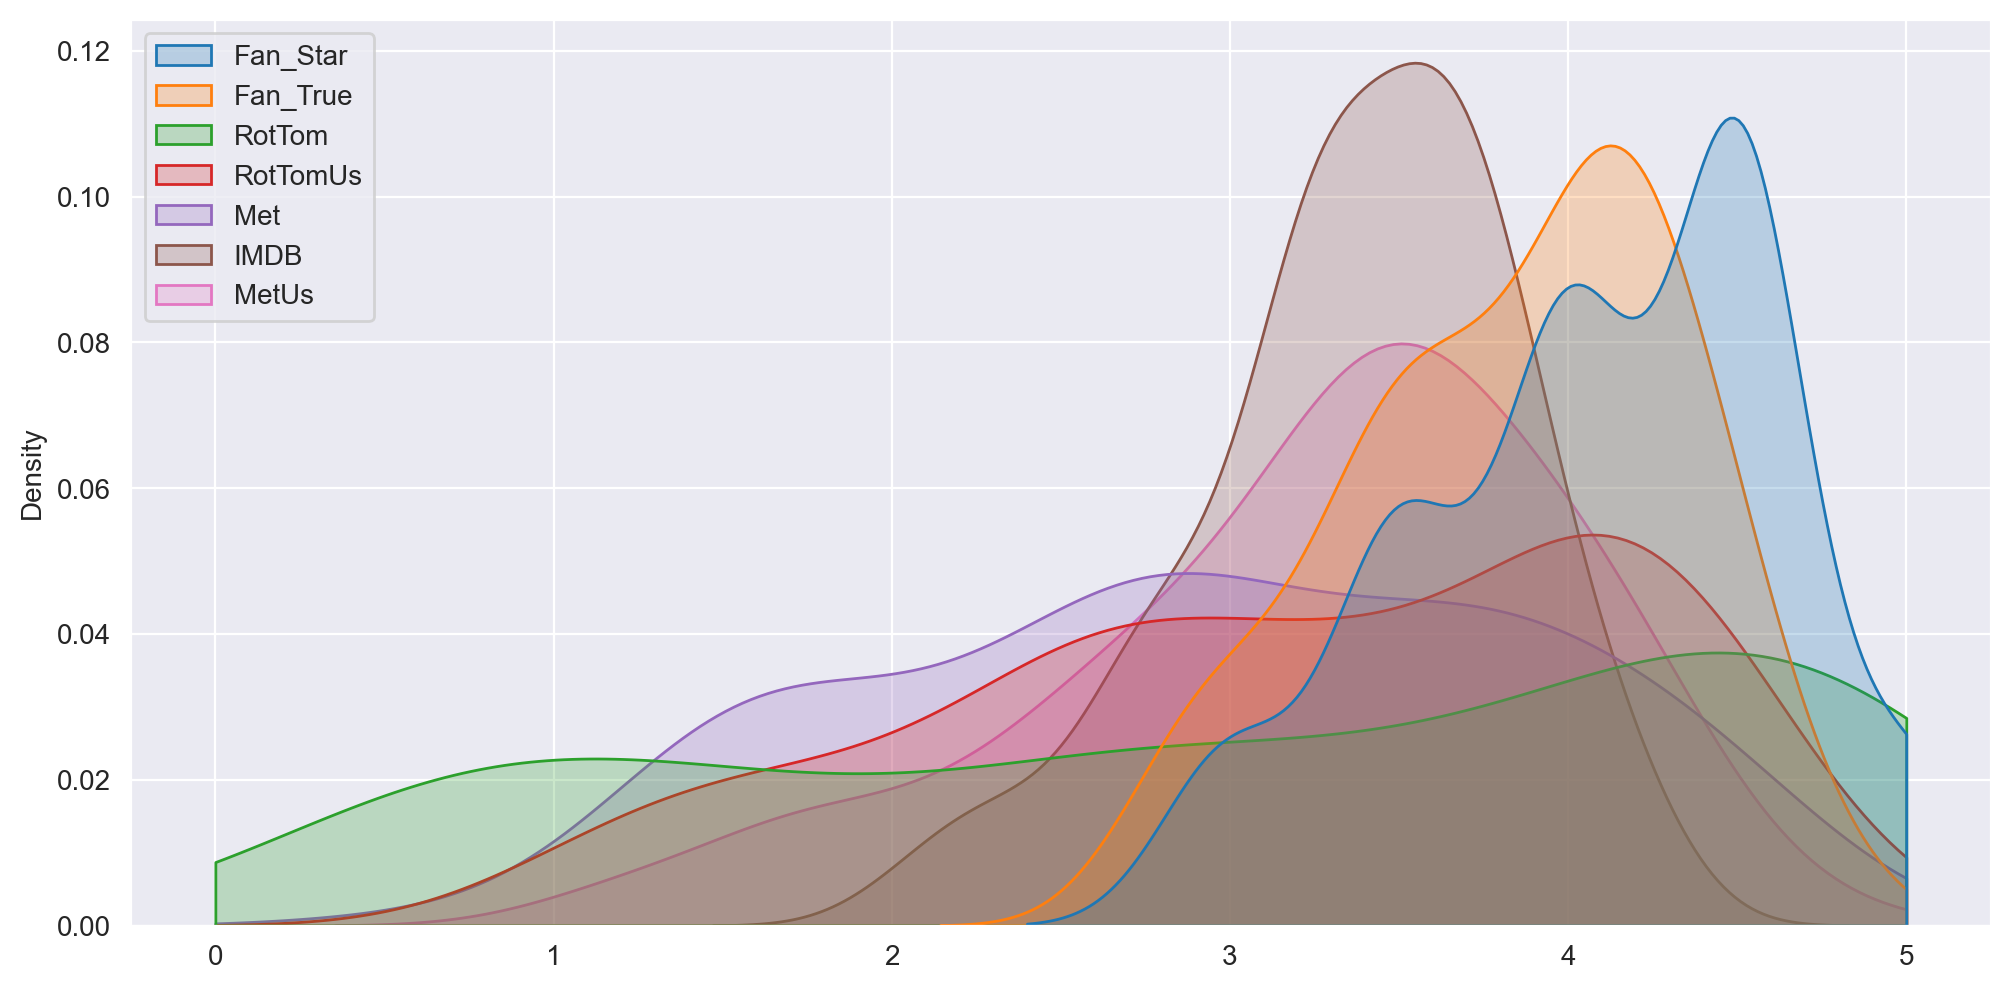

In [64]:
# plot
plt.figure(figsize=(12,6), dpi=200)
ax = sns.kdeplot(data=norm_df, shade=True, clip=[0,5])

move_legend(ax, "upper left")
plt.show()

**Clearly Fandango has an uneven distribution. We can also see that RottenTomatoe critics have the most uniform distribution. Let's directly compare these two.** 

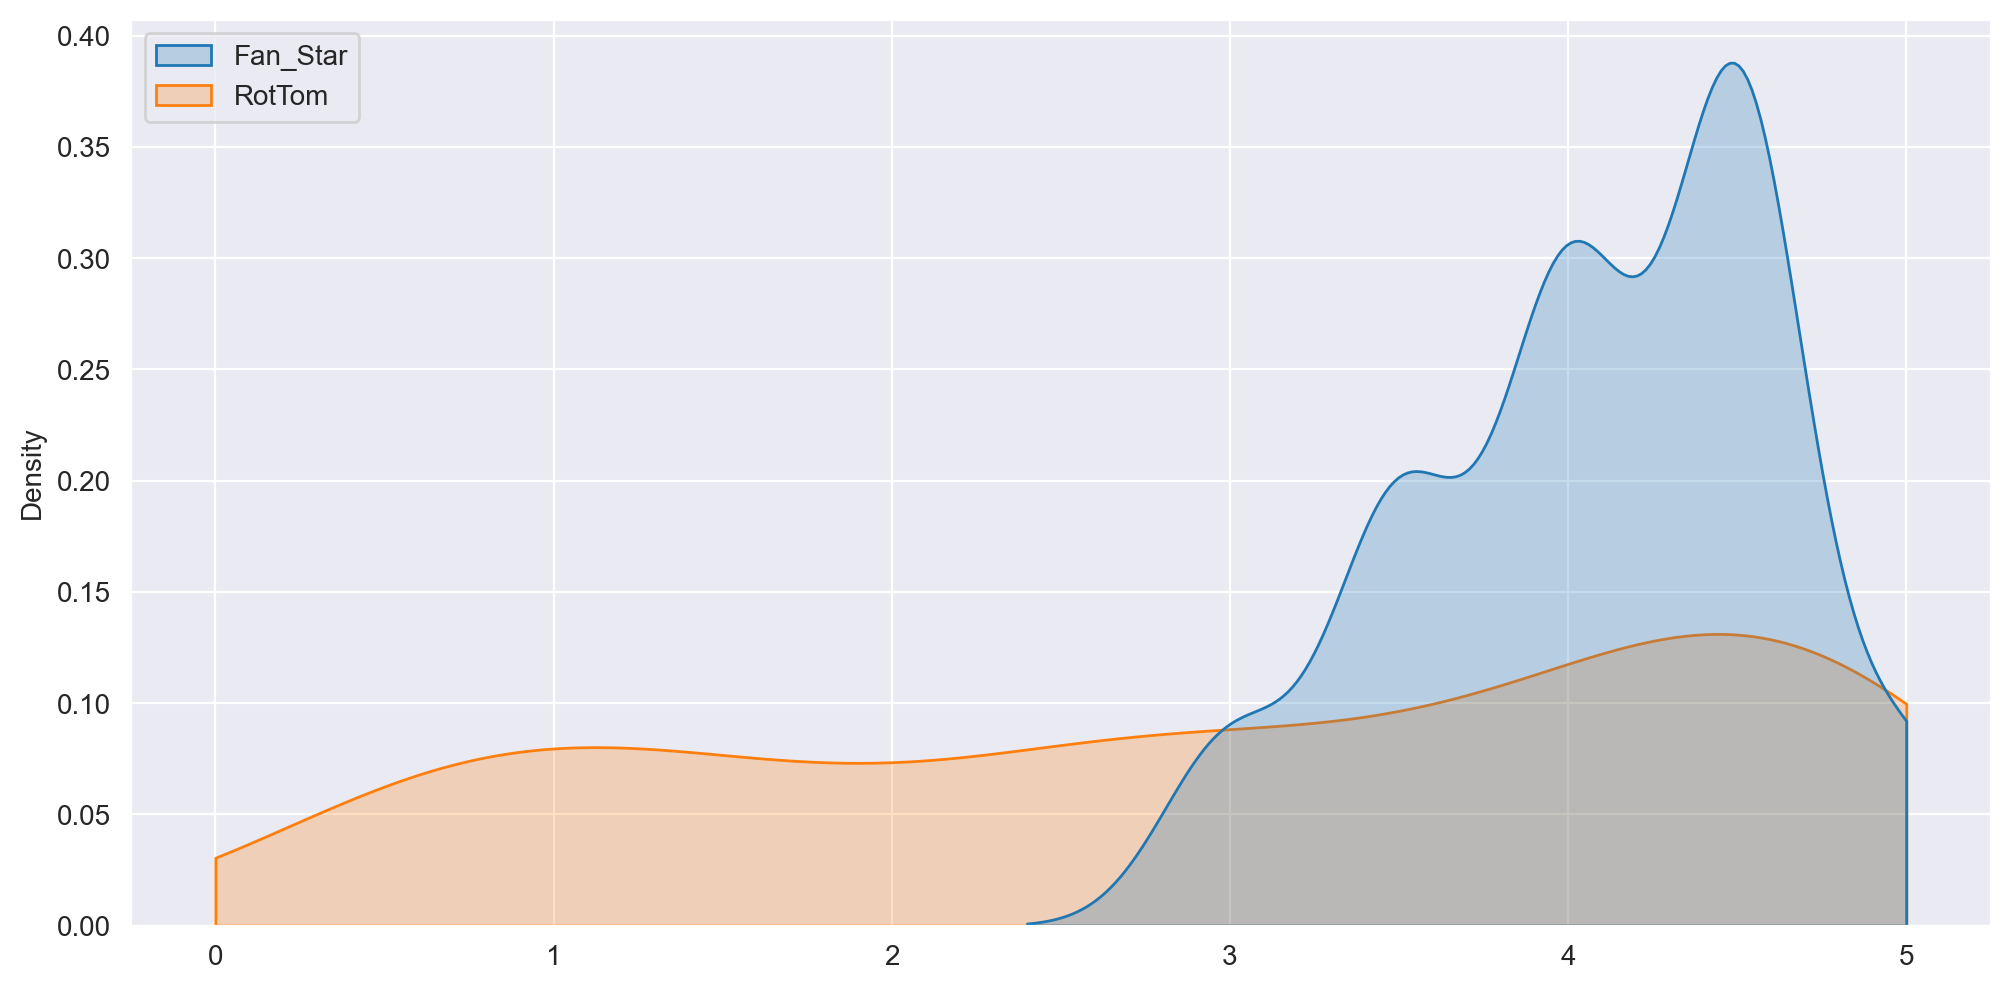

In [65]:
# plot
plt.figure(figsize=(12,6), dpi=200)
ax = sns.kdeplot(data=norm_df[['Fan_Star', 'RotTom']], shade=True, clip=[0,5])

move_legend(ax, "upper left")
plt.show()

**Next we create a histplot comparing all normalized scores.**

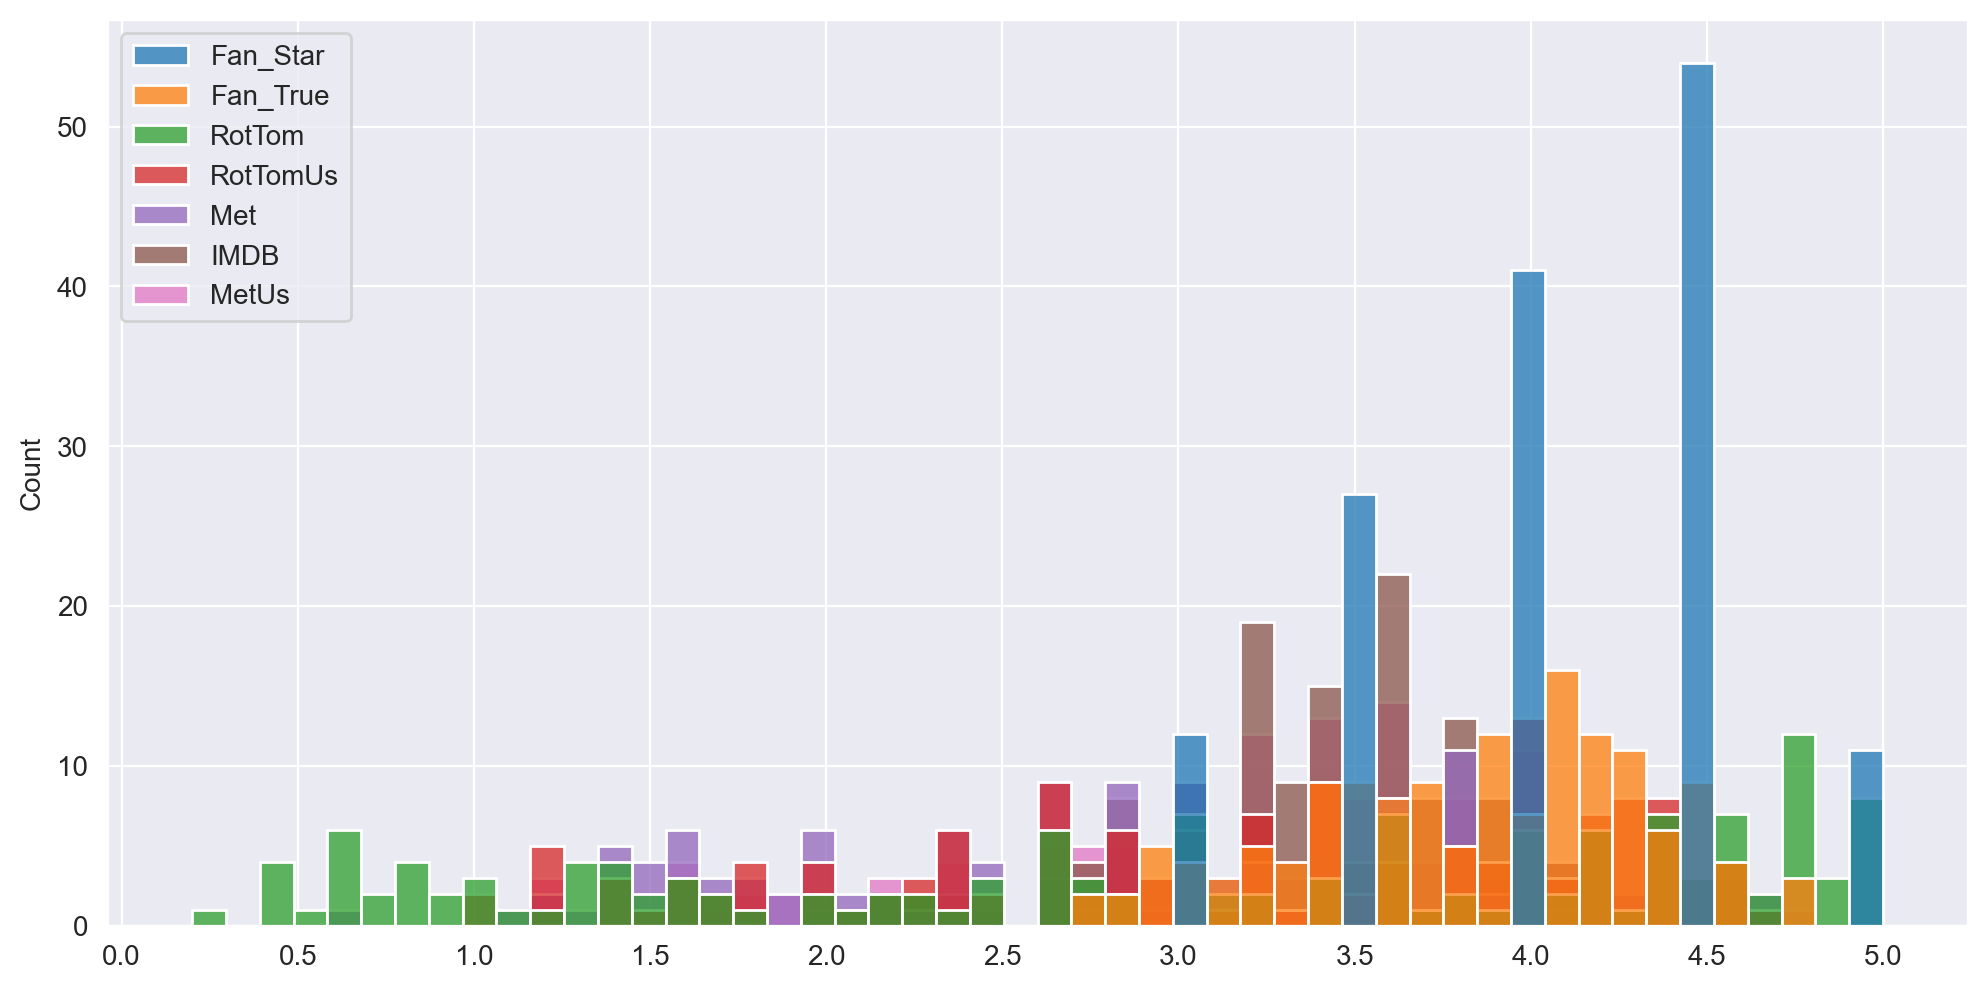

In [66]:
# plot 
plt.figure(figsize=(12,6), dpi=200)
ax = sns.histplot(data=norm_df, bins=50)

move_legend(ax, "upper left")
plt.xticks(np.linspace(0,5,11))
plt.show()

**Now we can clearly see, that around 40 films has too much stars (Fan_Star) around 4 in comparison to rating (Fan_True) and all the rest reviews. Furthermore over 50 films has been given too much stars (value 4.5). Smaller difference at 3.5 stars**


### How are the worst movies rated across all platforms?

**Clustermap visualization of all normalized scores. Note the differences in ratings, highly rated movies should be clustered together versus poorly rated movies.**

<Figure size 2400x1200 with 0 Axes>

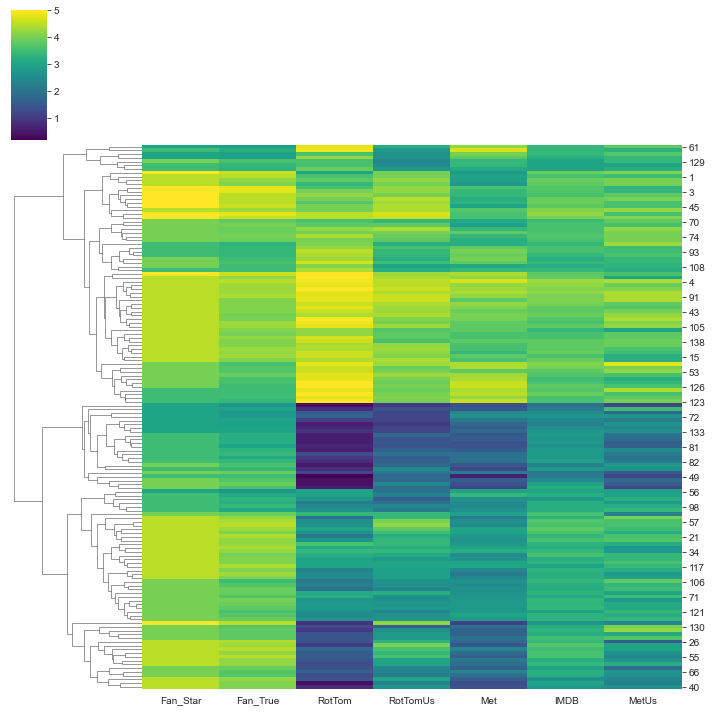

In [67]:
# plot itself
plt.figure(figsize=(12,6), dpi=200)
ax = sns.clustermap(data=norm_df.drop("FILM", axis=1), cmap='viridis', col_cluster=False)
plt.show()

**Clearly Fandango is rating movies much higher than other sites, especially considering that it is then displaying a rounded up version of the rating. Let's examine the top 10 worst movies.** 


**Finally let's visualize the distribution of ratings across all sites for the top 10 worst movies.**

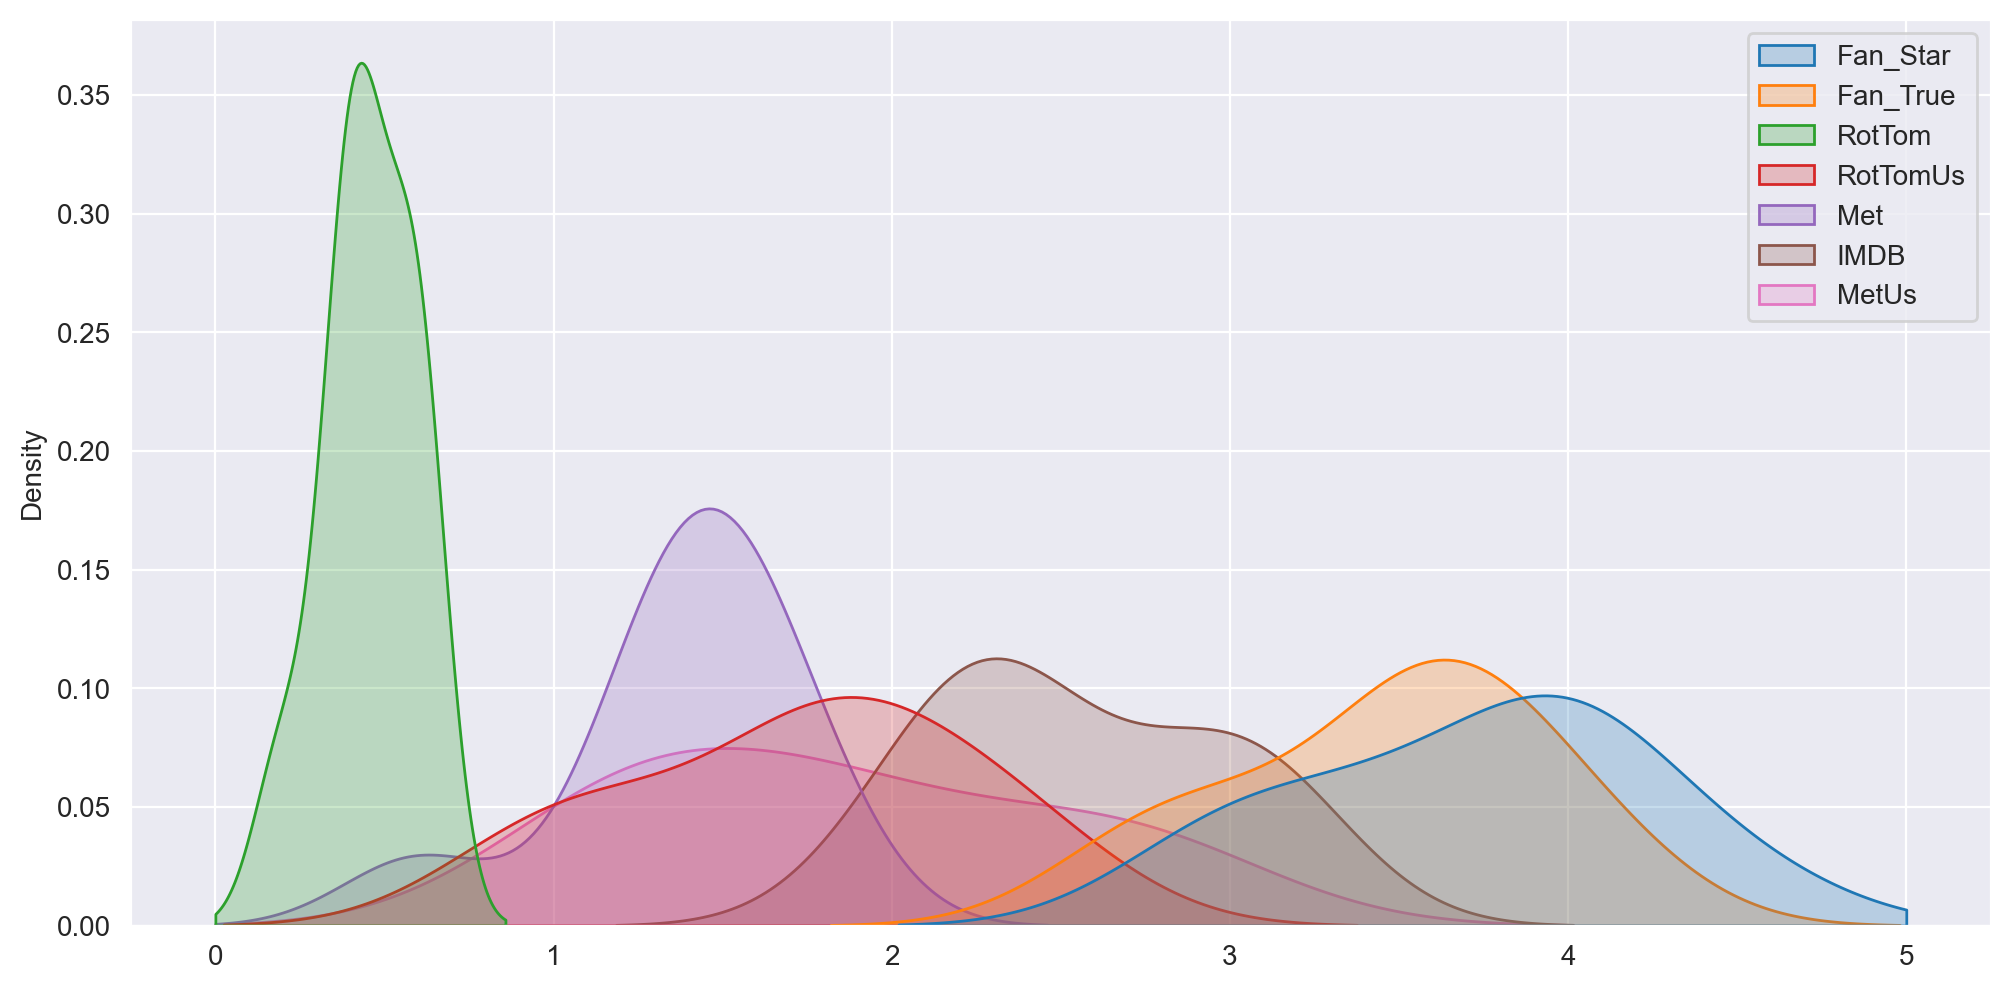

In [68]:
# plot itself
plt.figure(figsize=(12,6), dpi=200)
ax = sns.kdeplot(data=norm_df.sort_values('RotTom')[0:9], shade=True, clip=[0,5])

plt.show()

In [69]:
# check the exact values
norm_df.sort_values('RotTom_Norm')[0:9]

KeyError: 'RotTom_Norm'

---
----
# Final thoughts: 
**Fandango is showing around 3-4 star ratings for films that are clearly bad! Notice the biggest offender, Taken 3!. Fandango is displaying 4.5 stars on their site for a film with an average rating of 1.86 across the other platforms!**

---
----


In [ ]:
# let's also check films with biggest difference
df_comp.sort_values('FanStar-Mean', ascending=False).head(10)

First film - **Do You Believe?** has the higher difference, but we can see that RottenTomatotes scored that film 4.2/5 so the case may not be that clear. 

Next 4 films with **Taken 3** in the lead give a clear picture, that all other services rated films much lower then Fandango - also  we can see Fandango overstate the stars rating.

----


<img src="https://upload.wikimedia.org/wikipedia/en/6/6f/Taken_3_poster.jpg">